In [1]:
import os
import torch
import wandb

import pytorch_lightning as pl
import numpy as np

from tqdm.notebook import tqdm
from argparse import ArgumentParser
from represent.datamodules.uc2_landcover_datamodule import UC2LandCoverDataModule
from represent.models.uc2_supervised_resnet import UC2ResNet
from represent.callbacks.delayed_unfreeze import DelayedUnfreeze
from represent.models.moco import DualMoco
from represent.transforms.augmentations import get_data_augmentation
from represent.tools.utils import seed_all
from represent.tools.plots import plot_img_grid

from pl_bolts.models.regression import LogisticRegression
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime

from tqdm import tqdm

torch.backends.cudnn.benchmark = True

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
config = dict(
    data_dir = "/data/lloyd/RepreSent/UC2",
    seed = 420,
    batch_size = 64,
    image_size = 610,
    backbone = "resnet18",
    simplified_classes = False,
    segmentation = False,
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    workers = 16,
    max_epochs = 50,
    learning_rate = 0.0006, #0.00019498445997580445 All Moco
    use_mlp = True,
    num_classes = 26,
    input_ch = 13,
    checkpoint = "represent/MoCo_Pretrain_2022-09-07_17:18:50/epoch=131-val_loss=6.45.ckpt"
#     checkpoint = "represent/represent/weights/dualmoco_resnet50.pth"
#     checkpoint = "represent/represent/weights/simclr_resnet50.pth"
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC2ResNet.add_model_specific_args(parser)
parser = UC2LandCoverDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])

Global seed set to 420


In [3]:
wandb.finish()

In [3]:
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC2_ResNet_{ts}"
logger = WandbLogger(project="RepreSent_UC2", name=run_name, log_model=True, save_code=True)
# logger=None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [4]:
keep_classes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24])

uc2_datamodule = UC2LandCoverDataModule.from_argparse_args(args, 
                                                           transform=get_data_augmentation(cropsize=48), 
                                                           keep_classes=keep_classes)


In [5]:
classifier = LogisticRegression(input_dim=2048, num_classes=config['num_classes'])
classifier = classifier.linear

args.classification_head = torch.nn.Linear(512, config['num_classes'])

model = UC2ResNet(**args.__dict__)
# model = UC2ResNet(**args.__dict__)

# Load MoCo weights
Load the MoCo weights and remap the names to match a standard ResNet implementation

In [6]:
model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s2_moco.encoder_q")

_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['model.fc.2.weight', 'model.fc.2.bias'])

# Fine tune the model

In [7]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC2_MoCo/{run_name}',
    filename="{epoch}-{val_acc:.2f}",
    monitor="val_acc",
    mode="max",
    save_last=True,
)

# early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

unfreezer = DelayedUnfreeze(backbone_id="model", unfreeze_at_epoch=5)

callbacks = [checkpointer]

# for p in model.model.parameters():
#     p.requires_grad = False

In [8]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
run = trainer.fit(model, datamodule=uc2_datamodule)

training tiles: ['37MBM', '37MCM', '37MCN', '37MDN', '36LZL', '36LZM', '36LZN', '36LZP', '36LZR', '36MZS', '37LBG', '37LBJ', '37LBK', '37LCF', '37LCG', '37LCJ', '37LCK', '37LCL', '37LDG', '37LDH', '37LDK', '37LDL']
validation tiles: ['37LCH' '36LZQ' '37LBF' '37MBN']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | model      | ResNet | 11.5 M
1 | classifier | Linear | 13.3 K
--------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.935    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Tune Learning Rate

training tiles: ['37MBN', '37MCM', '37MCN', '37MDN', '36LZL', '36LZM', '36LZN', '36LZQ', '36LZR', '36MZS', '37LBF', '37LBG', '37LBJ', '37LBK', '37LCG', '37LCH', '37LCJ', '37LCK', '37LCL', '37LDG', '37LDH', '37LDL']
validation tiles: ['36LZP' '37LCF' '37MBM' '37LDK']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.000602559586074358
Restoring states from the checkpoint path at /home/lloyd/Documents/Experiments/RepreSent/.lr_find_c53bbe56-2afa-4334-bfc7-d672df17306a.ckpt


0.000602559586074358

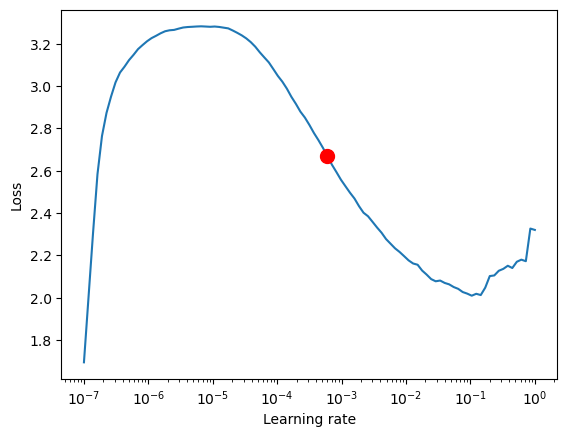

In [12]:
lr_finder = trainer.tune(model, datamodule=uc2_datamodule, lr_find_kwargs={"min_lr": 1e-7, "max_lr": 1,})

fig=lr_finder['lr_find'].plot(suggest=True)
fig.show()
lr_finder['lr_find'].suggestion()

# Evaluate the Trained Model

In [36]:
from glob import glob

checkpoints = glob(f"checkpoints/UC2_MoCo/{run_name}/*.ckpt")

print("Using checkpoint ", len(checkpoints),checkpoints[1])

model.load_from_checkpoint(checkpoints[1])
model = model.to('cuda')

Using checkpoint  2 checkpoints/UC2_MoCo/UC2_ResNet_2022-09-07_13:15:56/epoch=1-val_acc=0.42.ckpt


In [41]:
from tqdm.notebook import tqdm

datamodule = UC2LandCoverDataModule.from_argparse_args(args, keep_classes=keep_classes, batch_size=128)

datamodule.setup(stage="test")

preds = []
targets = []

for batch in tqdm_notebook(datamodule.test_dataloader()):
    x, y_true = batch
    x, y_true = x.to('cuda'), y_true.to('cuda')
    y_pred = model(x)
    
    preds.append(y_pred.argmax(1).detach().cpu().numpy())
    targets.append(y_true.detach().cpu().numpy())

/tmp/ipykernel_103042/3632695105.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(datamodule.test_dataloader()):


  0%|          | 0/1007 [00:00<?, ?it/s]

<AxesSubplot:xlabel='predicted', ylabel='true'>

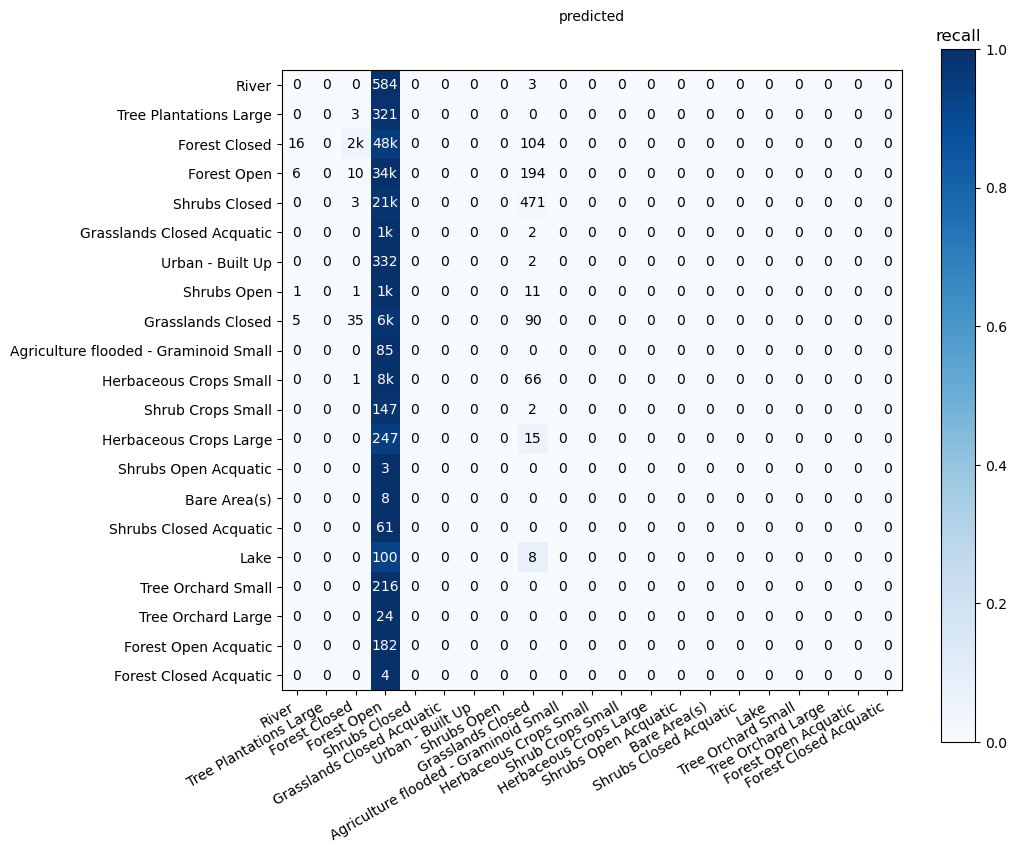

In [46]:
from represent.tools.plots import plot_confusion_matrix, print_classification_report
from represent.datamodules.uc2_landcover_datamodule import CLASSNAMES


preds = np.concatenate(preds)
targets = np.concatenate(targets)

plot_confusion_matrix(targets, preds, CLASSNAMES)

In [ ]:
keep_classes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24])
len(keep_classes)

  0%|                                                                                                                                                                                                                | 0/9334 [00:00<?, ?it/s]


tensor([4, 4, 4, 4, 4, 4, 3, 4, 4, 9, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4])


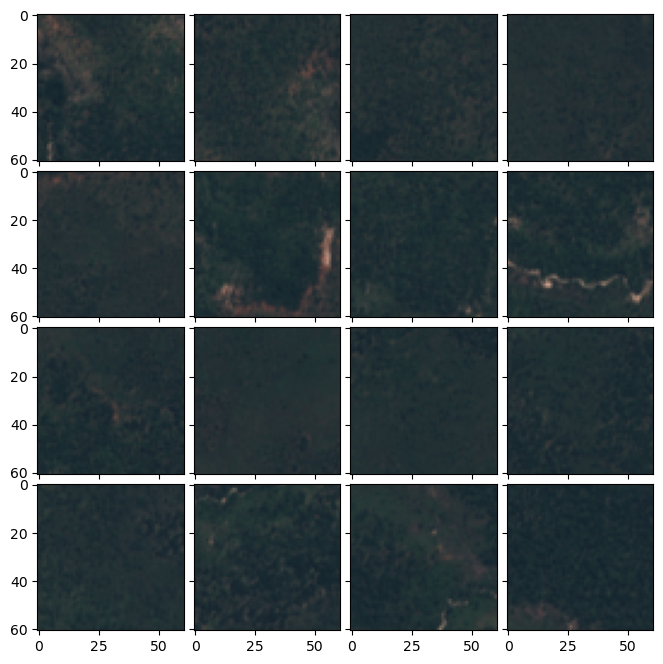

In [22]:
# datamodule = UC2LandCoverDataModule.from_argparse_args(args, keep_classes=keep_classes)
# datamodule.setup("fit")
# dl_iter = iter(datamodule.train_dataloader())

for batch in tqdm(dl_iter):
    x,y = batch
    break

print(y)
plot_img_grid((x*10000)/4000)